## 时间序列模拟器优化思路
### 一、清晰的层次结构
    1.长度、颗粒度
    2.季节项特征
    3.趋势项特征
    4.残差项特征
    5.故障特征
    6.......
### 二、易于理解的描述
    将专业词汇尽量转换为通俗易懂的描述
    eg:【季节项】定性为：天周期/周周期/任意间隔/.../无，定量0～∞
    eg:【趋势项】定性为：线性上升/线性下降/无，定量0～100
    eg:【残差项】定性为：正态分布/偏正态分布/.../无，定量0～∞
    eg:zscore等可以描述为异常度0～100等
    ......
### 三、故障特征优化
    1.故障时长和特征：例如持续5分钟的突增/持续2分钟的突降/......
    2.随机性故障：单个故障/多个故障，单个故障指定时间，多个故障指定数量
    3.重复性故障：每天重复时刻或相近时刻发生故障
### 四、特殊日模拟（思考）
    1.指定特殊日区间
    2.模拟特殊日的数据特征
---------------------------------------------------------------------------

# 指标算法交互式文档
    
### 功能模块
* 0.自定义函数
* 1.模块导入
* 2.读取数据
* 3.数据探查
* 4.算法选择
* 5.检测设置
* 6.异常检测
* 7.趋势预测

### 算法简介
    
* Dtmos 算法是一种单指标异常检测算法，主要适用于如交易量等的周期变化的指标数据。算法通过历史信息生成实时基线和对应拟合值的算法，最短需要历史两天的数据，支持实时检测，随着数据量的累积，自适应地选取周期信息进行基线拟合，通过数据的波动和基线进行异常判定。


  
* Spider 算法是一种单指标异常检测算法，主要适用于如机器性能指标等非周期变化的指标数据。算法基于核密度估计，在无需假设数据分布的条件下估计未知密度函数。最短需要历史一天的数据，支持实时检测可以自动识别指标模式变换及趋势偏移，适用于各种类型性能指标及业务类指标的异常检测。


    
* Prophet 算法是一种单指标预测算法，它考虑了时序数据通常具备的特性：趋势性、季节性，以及在生产生活中常见的节假日效应，并在趋势项中考虑了时间序列存在的变点，以此结合机器学习方法进行分段线性拟合或分段逻辑回归，从而较好的适应数据中易出现波动变化的趋势项，最终做出对未来的评估。

## 0.自定义函数

In [1]:
###上传csv数据
def load_csv(upload):
    global df
    df=pd.DataFrame()
    df=pd.read_csv(io.BytesIO(upload[0]['content'])) if upload else pd.DataFrame()
    if not upload:
        print('--------------------------------------------请上传csv数据-------------------------------------------------')
    return df

### 10位时间戳转日期字符串
def timestamp2str(timestamp):
    time_str=time.strftime("%Y-%m-%d %H:%M:%S",time.localtime(timestamp))
    return time_str

### 日期字符串转10位时间戳
def str2timestamp(time_str,format="%Y-%m-%d %H:%M:%S"):
    timestamp = time.mktime(time.strptime(t, format))
    return timestamp
    

###时间列和页面聚合窗口设定
def data_params():
    time_field=widgets.Text(value='',placeholder='Please input time_field',description='时间列',disabled=False)
    value_field=widgets.Text(value='',placeholder='Please input value_field',description='值列',disabled=False)
    interval=widgets.IntText(value=60,description='聚合粒度',disabled=False)
    method=widgets.Dropdown(options=['mean','max','min','sum','count'],value='mean',description='聚合方式:',disabled=False)
    display(widgets.HBox([time_field,value_field,interval,method]))
    return time_field,value_field,interval,method

###探索数据
def data_explore():
    print('--------------------------------------------数据特征-------------------------------------------------')
    print(f"{df.shape[0]} rows and {df.shape[1]} cols")
    table=PrettyTable(["特征","描述"])
    table.add_row(["开始时间",df[time_field.value].iloc[0]])
    table.add_row(["结束时间",df[time_field.value].iloc[-1]])
    table.add_row(["数据最大值",df[value_field.value].max()])
    table.add_row(["数据最小值",df[value_field.value].min()])
    table.add_row(["数据平均值",df[value_field.value].mean()])
    table.add_row(["数据标准差",df[value_field.value].std()])
    table.align='l'
    print(table)
    
    
###展示数据
def data_show():
    fig = go.Figure()
    if method.value=="count":
        temp_df=copy.deepcopy(df)
        temp_df['count']=1
        temp_df.index=pd.to_datetime(temp_df[time_field.value])
        temp_df=temp_df.resample(f'{interval.value}S').sum()
        temp_df[time_field.value]=temp_df.index
        fig.add_trace(go.Scatter(x=temp_df[time_field.value], y=temp_df['count'], opacity=0.75, mode='lines', name=f'{value_field.value} count',line=dict(width=2)))
        xtitle='time'
        ytitle='count'
        title_name=f'数据量变化图'
    else:
        if value_field.value not in df.columns:
            print(f'{value_field.value} not in df.columns')
            return fig       
        if interval.value==-1:
            fig.add_trace(go.Scatter(x=df[time_field.value], y=df[value_field.value], opacity=0.75, mode='lines', name=field,line=dict(width=2)))
        else:
            temp_df=df.loc[:,[time_field.value,value_field.value]]
            temp_df.index=pd.to_datetime(temp_df[time_field.value])
            if method.value=="mean":
                temp_df=temp_df.resample(f'{interval.value}S').mean()
            if method.value=="max":
                temp_df=temp_df.resample(f'{interval.value}S').max()
            if method.value=="min":
                temp_df=temp_df.resample(f'{interval.value}S').min()
            if method.value=="sum":
                temp_df=temp_df.resample(f'{interval.value}S').sum()
            temp_df[time_field.value]=temp_df.index
            fig.add_trace(go.Scatter(x=temp_df[time_field.value], y=temp_df[value_field.value], opacity=0.75, mode='lines', name=value_field.value,line=dict(width=2)))
        xtitle='time'
        ytitle=value_field.value
        title_name=f'指标时序图' 
    fig.update_layout(autosize=False, width=1000, height=600,xaxis_title=xtitle,yaxis_title=ytitle,title={"text":title_name,"x":0.5})
    return fig

###Dtmos检测设置
def dtmos_config():
    a1=widgets.ToggleButtons(options=['检测模式设定'],description='',disabled=False,button_style='danger')
    detect_mode=widgets.Select(options=['均检测','仅检测上基带异常', '仅检测下基带异常'],value='均检测',description='',disabled=False)
    mode=widgets.HBox([a1,detect_mode])
    
    a2=widgets.ToggleButtons(options=['周期设定'],description='',disabled=False,button_style='danger')
    season_mode=widgets.Select(options=['周周期', '天周期'],value='周周期',description='',disabled=False)
    season=widgets.HBox([a2,season_mode])
    
    a3=widgets.ToggleButtons(options=['基带边界设定'],description='',disabled=False,button_style='danger')
    upper_constant=widgets.FloatText(value=-1,description=f'上边界',disabled=False)
    lower_constant=widgets.FloatText(value=-1,description=f'下边界',disabled=False)
    constant=widgets.HBox([a3,upper_constant,lower_constant])
    
    a4=widgets.ToggleButtons(options=['基带补偿设定'],description='',disabled=False,button_style='danger')
    max_value=widgets.FloatText(value=-1,description=f'最大值',disabled=False)
    min_value=widgets.FloatText(value=-1,description=f'最小值',disabled=False)
    compensate_mode=widgets.Select(options=['越接近最大值基带越窄','越接近最小值基带越窄', '越接近最大值/最小值基带越窄'],value='越接近最大值基带越窄',description='',disabled=False)
    coe=widgets.FloatSlider(value=0.1,min=0,max=1.0,step=0.01,description='补偿系数',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    compensate=widgets.HBox([a4,max_value,min_value,compensate_mode,coe])
    
    a5=widgets.ToggleButtons(options=['拟合参数设定'],description='',disabled=False,button_style='danger')
    trend_prop=widgets.FloatSlider(value=0,min=0,max=1.0,step=0.01,description='趋势权重',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    window=widgets.IntSlider(value=0,min=0,max=60,step=1,description='拟合窗口',disabled=False,continuous_update=False,orientation='horizontal',readout=True)
    smooth_window=widgets.IntSlider(value=30,min=0,max=100,step=1,description='基带平滑窗口',disabled=False,continuous_update=False,orientation='horizontal',readout=True)
    fit_params=widgets.HBox([a5,trend_prop,window,smooth_window])
    
    children = [mode,season,constant,compensate,fit_params]
    tab = widgets.Tab()
    tab.children = children
    tab.titles = ['检测模式设定','周期设定','基带边界设定','基带补偿设定','拟合参数设定']
    display(tab)
    return detect_mode,season_mode,upper_constant,lower_constant,max_value,min_value,compensate_mode,coe,trend_prop,window,smooth_window

###Spider检测设置
def spider_config():
    a1=widgets.ToggleButtons(options=['检测模式设定'],description='',disabled=False,button_style='danger')
    detect_mode=widgets.Select(options=['均检测','仅检测上基带异常', '仅检测下基带异常'],value='均检测',description='',disabled=False)
    mode=widgets.HBox([a1,detect_mode])
    
    a2=widgets.ToggleButtons(options=['周期设定'],description='',disabled=False,button_style='danger')
    season_mode=widgets.Select(options=['周周期', '天周期','无周期'],value='无周期',description='',disabled=False)
    window=widgets.IntSlider(value=0,min=0,max=60,step=1,description='周期窗口',disabled=False,continuous_update=False,orientation='horizontal',readout=True)
    fit_quantile=widgets.FloatSlider(value=0.5,min=0,max=1.0,step=0.01,description='周期分位点',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    season=widgets.HBox([a2,season_mode,window,fit_quantile])
    
    a3=widgets.ToggleButtons(options=['基带边界设定'],description='',disabled=False,button_style='danger')
    upper_constant=widgets.FloatText(value=-1,description=f'上边界',disabled=False)
    lower_constant=widgets.FloatText(value=-1,description=f'下边界',disabled=False)
    constant=widgets.HBox([a3,upper_constant,lower_constant])
    
    a4=widgets.ToggleButtons(options=['基带补偿设定'],description='',disabled=False,button_style='danger')
    max_value=widgets.FloatText(value=-1,description=f'最大值',disabled=False)
    min_value=widgets.FloatText(value=-1,description=f'最小值',disabled=False)
    compensate_mode=widgets.Select(options=['越接近最大值基带越窄','越接近最小值基带越窄', '越接近最大值/最小值基带越窄'],value='越接近最大值基带越窄',description='',disabled=False)
    coe=widgets.FloatSlider(value=0.1,min=0,max=1.0,step=0.01,description='补偿系数',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    compensate=widgets.HBox([a4,max_value,min_value,compensate_mode,coe])
    
    a5=widgets.ToggleButtons(options=['拟合参数设定'],description='',disabled=False,button_style='danger')
    trend_prop=widgets.FloatSlider(value=0,min=0,max=1.0,step=0.01,description='趋势权重',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    estimate_window=widgets.IntSlider(value=60,min=0,max=300,step=5,description='影响范围窗口',disabled=False,continuous_update=False,orientation='horizontal',readout=True)
    smooth_window=widgets.IntSlider(value=30,min=0,max=100,step=1,description='基带平滑窗口',disabled=False,continuous_update=False,orientation='horizontal',readout=True)
    fit_params=widgets.HBox([a5,trend_prop,estimate_window,smooth_window])
    
    a6=widgets.ToggleButtons(options=['周期异常消除设定'],description='',disabled=False,button_style='danger')
    anomaly_condition=widgets.Text(value='day,7,3',description='异常条件',disabled=False)
    anomaly_threshold=widgets.FloatSlider(value=0.75,min=0,max=1.0,step=0.01,description='异常阈值',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    anomaly_drop=widgets.HBox([a6,anomaly_condition,anomaly_threshold])
    
    children = [mode,season,constant,compensate,fit_params,anomaly_drop]
    tab = widgets.Tab()
    tab.children = children
    tab.titles = ['检测模式设定','周期设定','基带边界设定','基带补偿设定','拟合参数设定','周期异常消除设定']
    display(tab)
    return detect_mode,season_mode,window,fit_quantile,upper_constant,lower_constant,max_value,min_value,compensate_mode,coe,trend_prop,estimate_window,smooth_window,anomaly_condition,anomaly_threshold

###预测设置
def predict_config():
    a1=widgets.ToggleButtons(options=['预测时长设定'],description='',disabled=False,button_style='danger')
    period=widgets.IntText(value=3,description=f'预测时长',disabled=False)
    freq=widgets.Select(options=['天','小时', '分钟'],value='天',description='',disabled=False)
    predict_period=widgets.HBox([a1,period,freq])

    a2=widgets.ToggleButtons(options=['变点设定'],description='',disabled=False,button_style='danger')
    n_changepoints=widgets.IntText(value=20,description=f'变点数量',disabled=False)
    changepoints=widgets.Text(value='',placeholder='例“2020-09-28 16:05:00”',description='自定义变点',disabled=False)
    change_prior=widgets.FloatSlider(value=0.05,min=0,max=1.0,step=0.01,description='变点拟合强度',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    changes=widgets.HBox([a2,n_changepoints,changepoints,change_prior])

    a3=widgets.ToggleButtons(options=['周期拟合设定'],description='',disabled=False,button_style='danger')
    daily=widgets.Select(options=['自动','拟合','不拟合'],value='自动',description='天周期',disabled=False)
    weekly=widgets.Select(options=['自动','拟合','不拟合'],value='自动',description='周周期',disabled=False)
    seasonal_prior=widgets.FloatSlider(value=10,min=0,max=100,step=1,description='周期拟合强度',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    season=widgets.HBox([a3,daily,weekly,seasonal_prior])

    a4=widgets.ToggleButtons(options=['自定义周期设定'],description='',disabled=False,button_style='danger')
    add_seasonality=widgets.Text(value='',placeholder='例"20,5"',description='自定义周期',disabled=False)
    add_season=widgets.HBox([a4,add_seasonality])

    a5=widgets.ToggleButtons(options=['节假日设定'],description='',disabled=False,button_style='danger')
    holidays=widgets.Text(value='',placeholder='例“2018-10-01,0,6”',description='节假日',disabled=False)
    holiday=widgets.HBox([a5,holidays])

    a6=widgets.ToggleButtons(options=['预测基带设定'],description='',disabled=False,button_style='danger')
    upper_constant=widgets.FloatText(value=-1,description=f'上边界',disabled=False)
    lower_constant=widgets.FloatText(value=-1,description=f'下边界',disabled=False)
    interval_width=widgets.FloatSlider(value=0.8,min=0,max=1.0,step=0.05,description='基带宽度',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    constant=widgets.HBox([a6,upper_constant,lower_constant,interval_width])

    children = [predict_period,changes,season,add_season,holiday,constant]
    tab = widgets.Tab()
    tab.children = children
    tab.titles = ['预测时长设定','变点设定','周期拟合设定','自定义周期设定','节假日设定','预测基带设定']
    display(tab)
    return period,freq,n_changepoints,changepoints,change_prior,daily,weekly,seasonal_prior,add_seasonality,holidays,upper_constant,lower_constant,interval_width
    

###检测初始化
def detect_init():
    upper_width=widgets.FloatSlider(value=0.5,min=0,max=10,step=0.1,description='上基带宽度',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    lower_width=widgets.FloatSlider(value=0.5,min=0,max=10,step=0.1,description='下基带宽度',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f')
    return upper_width,lower_width


###检测算法运行
def detect(upper_width,lower_width):
    global result
    result=pd.DataFrame()
    train_data=df.loc[:,[time_field.value,value_field.value]]
    if detect_mode.value=="均检测":
        upper_detection=True
        lower_detection=True
    if detect_mode.value=="仅检测上基带异常":
        upper_detection=True
        lower_detection=False
    if detect_mode.value=="仅检测下基带异常":
        upper_detection=False
        lower_detection=True
        
    if compensate_mode.value=="越接近最大值基带越窄":
        mode="negative"
    if compensate_mode.value=="越接近最小值基带越窄":
        mode='positive'
    if compensate_mode.value=="越接近最大值/最小值基带越窄":
        mode='both'
    
    if alg.value=="Dtmos":
        if season_mode.value=="周周期":
            seasonal="weekly"
        if season_mode.value=="天周期":
            seasonal="daily"     
        params=dict(time_field=time_field.value,
                    value_field=value_field.value,
                    granularity=interval.value,
                    window=window.value,
                    sensitivity=0.95,
                    max_trend_prop=trend_prop.value,
                    upper_width=upper_width,
                    lower_width=lower_width,
                    upper_detection=upper_detection,
                    lower_detection=lower_detection,
                    drop_suspicious=True,
                    min_value=min_value.value,
                    max_value=max_value.value,
                    compensate_mode=mode,
                    compensate_coefficient=coe.value,
                    seasonal=seasonal,
                    smooth_window=smooth_window.value,
                    upper_constant=upper_constant.value,
                    lower_constant=lower_constant.value)
        result = dtmosAlg.run(train_data,params)
    if alg.value=="Spider":
        if season_mode.value=="周周期":
            seasonal="weekly"
        if season_mode.value=="天周期":
            seasonal="daily"  
        if season_mode.value=="无周期":
            seasonal=""  
        params=dict(time_field=time_field.value,
                    value_field=value_field.value,
                    granularity=interval.value,
                    estimate_window=estimate_window.value,
                    affected_window=window.value,
                    likelihood_confidence=0.85,
                    kde_weight=0.6,
                    bandwidth=1.0,
                    kernel="gaussian",
                    upper_width=upper_width,
                    lower_width=lower_width,
                    trend_prop=trend_prop.value,
                    seasonal=seasonal,
                    drop_suspicious=True,
                    upper_detection=upper_detection,
                    lower_detection=lower_detection,
                    min_value=min_value.value,
                    max_value=max_value.value,
                    compensate_mode=mode,
                    compensate_coefficient=coe.value,
                    smooth_window=smooth_window.value,
                    fit_quantile=fit_quantile.value,
                    seasonal_anomaly_condition=anomaly_condition.value,
                    seasonal_anomaly_threshold=anomaly_threshold.value,
                    upper_constant=upper_constant.value,
                    lower_constant=lower_constant.value)
        result = spiderAlg.run(train_data,params)
    anomaly_result=result[result['anomaly']==1]
    print('--------------------------------------------算法结果-------------------------------------------------\n',
        "异常点数量(占比)："+str(len(anomaly_result))+"("+str(round(len(anomaly_result)/len(result),2)*100)+"%)"+"\n")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=anomaly_result[time_field.value], y=anomaly_result[value_field.value], opacity=1, mode='markers',name='anomaly', marker=dict(color='red', size=10)))
    fig.add_trace(go.Scatter(x=result[time_field.value], y=result['upper'], opacity=0, mode='lines', name='upper', fill=None,line=dict(color='#34A5DA', width=1)))
    fig.add_trace(go.Scatter(x=result[time_field.value], y=result['lower'], opacity=0, mode='lines', name='lower', fill='tonexty',line=dict(color='#34A5DA', width=1)))
    fig.add_trace(go.Scatter(x=result[time_field.value], y=result[value_field.value], opacity=0.6, mode='lines', name='data',line=dict(color='black', width=2)))
    fig.update_layout(autosize=False, width=1000, height=600)
    fig.show()
    show_result(anomaly_result,params,5,False)
    
def show_result(anomaly_result,params,show_nums,print_params):
    print('--------------------------------------------异常结果-------------------------------------------------')
    description=[]
    for i in range(len(anomaly_result)):
        value=anomaly_result[value_field.value].iloc[i]
        pre_value=anomaly_result['pre_value'].iloc[i]
        upper=anomaly_result['upper'].iloc[i]
        if value>upper:
            if value==0:
                desc="⬆ Unexpected zero"
            else:
                high=round(value/pre_value,1) if pre_value!=0 else round((value+(value-upper))/value,1)
                desc="⬆ "+str(high)+"x higher"
        else:
            if value==0:
                desc="⬇ Unexpected zero"
            else:
                low=round(pre_value/value,1)
                desc="⬇ "+str(low)+"x lower"
        description.append(desc)
    anomaly_result['description']=description
    anomaly_result=anomaly_result.sort_values(by=['abnormality'],ascending=False)
    anomaly_result.reset_index(drop=True,inplace=True)
    table=PrettyTable(["编号","时间","预期值","实际值","异常度","描述"])
    for k in range(min(show_nums,len(anomaly_result))):
        table.add_row([k+1,anomaly_result[time_field.value].iloc[k],round(anomaly_result['pre_value'].iloc[k],2),round(anomaly_result[value_field.value].iloc[k],2),anomaly_result['abnormality'].iloc[k],anomaly_result['description'].iloc[k]])
    print(table)
    print('--------------------------------------------参数取值-------------------------------------------------')
    table1=PrettyTable(["param","value"])
    for key in params.keys():
        table1.add_row([key,params[key]])
    table1.align='l'
    if print_params:
        print(table1)   
    
###预测算法运行
def predict():
    global forecast
    forecast=pd.DataFrame()
    period,freq,n_changepoints,changepoints,change_prior,daily,weekly,seasonal_prior,add_seasonality,holidays,upper_constant,lower_constant,interval_width
    
    if freq.value=="天":
        gran="D"
    if freq.value=="小时":
        gran="h"
    if freq.value=="分钟":
        gran="min"
        
    if weekly.value=="自动":
        weekly_seasonality="auto"
    if weekly.value=="拟合":
        weekly_seasonality="T"
    if weekly.value=="不拟合":
        weekly_seasonality="F"   
        
    if daily.value=="自动":
        daily_seasonality="auto"
    if daily.value=="拟合":
        daily_seasonality="T"
    if daily.value=="不拟合":
        daily_seasonality="F" 
      
    params=dict(time_field=time_field.value,
                value_field=value_field.value,
                granularity=interval.value,
                periods=period.value,
                freq=gran,
                n_changepoints=n_changepoints.value,
                changepoints=changepoints.value,
                weekly_seasonality=weekly_seasonality,
                daily_seasonality=daily_seasonality,
                interval_width=interval_width.value,
                seasonality_prior_scale=seasonal_prior.value,
                changepoint_prior_scale=change_prior.value,
                holidays=holidays.value,
                add_seasonality=add_seasonality.value,
                upper_constant=upper_constant.value,
                lower_constant=lower_constant.value)
    train_data=df.loc[:,[time_field.value,value_field.value]]
    forecast,changes = fbProphet.run(params,train_data)
    changes=[str(c) for c in changes]
    change_data=df[df[time_field.value].isin(changes)]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=forecast[time_field.value], y=forecast['yhat_upper'], opacity=0, mode='lines', name='upper', fill=None,line=dict(color='#34A5DA', width=1)))
    fig.add_trace(go.Scatter(x=forecast[time_field.value], y=forecast['yhat_lower'], opacity=0, mode='lines', name='lower', fill='tonexty',line=dict(color='#34A5DA', width=1)))
    fig.add_trace(go.Scatter(x=forecast[time_field.value], y=forecast['yhat'], opacity=1, mode='lines', name='fit',line=dict(color='lime', width=2)))
    fig.add_trace(go.Scatter(x=df[time_field.value], y=df[value_field.value], opacity=0.55, mode='lines', name='data',line=dict(color='black', width=2)))
    #fig.add_trace(go.Scatter(x=change_data[time_field.value], y=change_data[value_field.value], opacity=1, mode='markers',name='change_points', marker=dict(color='red', size=10)))
    fig.update_layout(autosize=False, width=1000, height=600)
    fig.show()

## 1.模块导入

In [2]:
import pandas as pd
import copy
import io
import datetime
import ipywidgets as widgets
from ipywidgets import interact
from prettytable import PrettyTable
from pandas.api.types import is_numeric_dtype
import plotly.graph_objects as go
from plotly import tools
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
import fbProphet
import Dtmos
#import Spider
dtmosAlg=Dtmos.Dtmos()
#spiderAlg=Spider.Spider()

## 2.读取数据

In [10]:
interact(load_csv,upload=widgets.FileUpload(accept='',multiple=False))
time_field,value_field,interval,method=data_params()

interactive(children=(FileUpload(value=(), description='Upload'), Output()), _dom_classes=('widget-interact',)…

<function __main__.load_csv(upload)>

## 3.数据探查

In [11]:
data_explore()
interact(data_show)

--------------------------------------------数据特征-------------------------------------------------
43836 rows and 8 cols
+------------+---------------------+
| 特征       | 描述                |
+------------+---------------------+
| 开始时间   | 2022-05-01 00:00:00 |
| 结束时间   | 2022-05-31 10:35:00 |
| 数据最大值 | 1.5                 |
| 数据最小值 | 0.0                 |
| 数据平均值 | 0.11541052877532167 |
| 数据标准差 | 0.1616859555619667  |
+------------+---------------------+


interactive(children=(Output(),), _dom_classes=('widget-interact',))

<function __main__.data_show()>

## 4.算法选择

In [12]:
alg=widgets.ToggleButtons(options=['Dtmos','Spider'],description='',disabled=False,button_style='danger')
display(alg)

ToggleButtons(button_style='danger', options=('Dtmos', 'Spider'), value='Dtmos')

## 5.检测设置

In [13]:
if alg.value=="Dtmos":
    detect_mode,season_mode,upper_constant,lower_constant,max_value,min_value,compensate_mode,coe,trend_prop,window,smooth_window=dtmos_config()
else:
    detect_mode,season_mode,window,fit_quantile,upper_constant,lower_constant,max_value,min_value,compensate_mode,coe,trend_prop,estimate_window,smooth_window,anomaly_condition,anomaly_threshold=spider_config()

## 6.算法运行

In [8]:
upper_width,lower_width=detect_init()
interact(detect,upper_width=upper_width,lower_width=lower_width)

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='上基带宽度', max=10.0), FloatSli…

<function __main__.detect(upper_width, lower_width)>

## 7.趋势预测

In [5]:
period,freq,n_changepoints,changepoints,change_prior,daily,weekly,seasonal_prior,add_seasonality,holidays,upper_constant,lower_constant,interval_width=predict_config()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -154.133
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       26630.7      0.010405       694.727           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       26708.4   0.000886273       1276.13      0.5329      0.5329      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       26739.5    0.00664833       604.134           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       26748.6   0.000157334       108.322      0.1987      0.8302      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       26752.8   0.000401648       203.709           1           1      586   
    Iter      log prob        ||dx||      ||grad||       alpha  

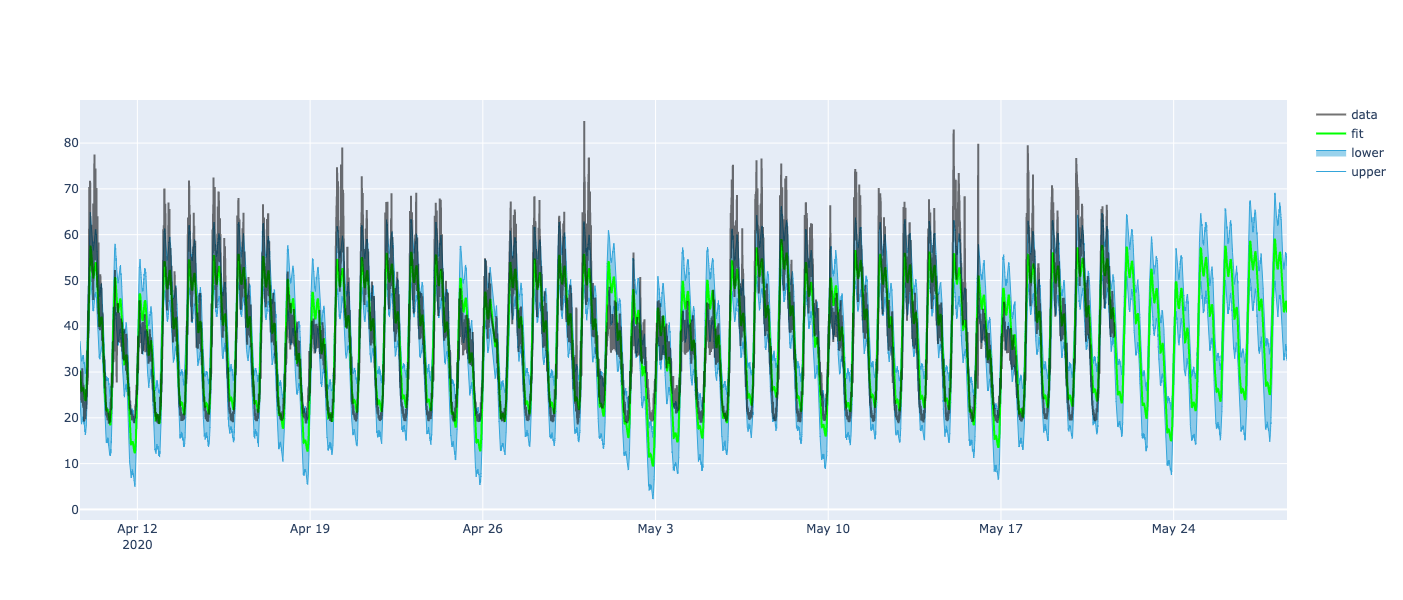

In [6]:
predict()